In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# !pip install fuzzywuzzy
# !pip install scikit-surprise

In [4]:
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SlopeOne
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV


In [5]:
from datetime import datetime
import os
import random
import gc

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [6]:
movies = pd.read_csv('movies.csv')
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [8]:
movies['newId'] = range(1, movies['movieId'].nunique() + 1)

In [9]:
movies.head(3)

,movieId,title,genres,newId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,2
2,3,Grumpier Old Men (1995),Comedy|Romance,3


In [10]:
movie_ratings = pd.read_csv('ratings.csv')
movie_ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [11]:
movie_ratings['timestamp'] = movie_ratings['timestamp'].apply(lambda x : datetime.utcfromtimestamp(x).strftime("%Y-%m-%d"))

In [12]:
movie_ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02
1,1,29,3.5,2005-04-02
2,1,32,3.5,2005-04-02
3,1,47,3.5,2005-04-02
4,1,50,3.5,2005-04-02


In [13]:
movie_ratings = movie_ratings.merge(movies, how = "left", on = "movieId")

In [14]:
movie_ratings.head()

,userId,movieId,rating,timestamp,title,genres,newId
0,1,2,3.5,2005-04-02,Jumanji (1995),Adventure|Children|Fantasy,2
1,1,29,3.5,2005-04-02,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,29
2,1,32,3.5,2005-04-02,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,32
3,1,47,3.5,2005-04-02,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,47
4,1,50,3.5,2005-04-02,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,50


In [15]:
movie_ratings.rename(columns = {"timestamp" : "date"}, inplace=True)

In [16]:
movie_ratings["movieId"] = movie_ratings['newId']
movies['movieId'] = movies['newId']

In [17]:
movie_ratings.drop(['newId'],axis=1, inplace=True)
movies.drop(['newId'], axis=1, inplace=True)

In [19]:
movie_ratings.sort_values(by="date", inplace=True)
movie_ratings.reset_index(drop=True, inplace=True)
# movies.sort_values(by="date", inplace=True)

In [20]:
print(movie_ratings.shape)
print(movie_ratings.columns)

(20000263, 6)
Index(['userId', 'movieId', 'rating', 'date', 'title', 'genres'], dtype='object')


Data Cleaning


In [21]:
movie_ratings.duplicated().sum()

0

No duplicates found

In [22]:
movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
 3   date     object 
 4   title    object 
 5   genres   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 915.5+ MB


In [23]:
movie_ratings.isna().sum()

userId     0
movieId    0
rating     0
date       0
title      0
genres     0
dtype: int64

## EDA

#### Univariate Analysis

In [24]:
movie_ratings.head(2)

,userId,movieId,rating,date,title,genres
0,131160,1058,3.0,1995-01-09,"Fish Called Wanda, A (1988)",Comedy|Crime
1,131160,47,5.0,1995-01-09,Seven (a.k.a. Se7en) (1995),Mystery|Thriller


In [26]:
total_users = movie_ratings['userId'].nunique()
print(total_users)

138493


In [27]:
# Top 5 user id's 
movie_ratings['userId'].value_counts()[:5]

userId
118205    9254
8405      7515
82418     5646
121535    5520
125794    5491
Name: count, dtype: int64

userId 118205 has around 9K records in the dataset.

In [29]:
# movieID
total_movies = movie_ratings['movieId'].nunique()
print("Total number of movies in dataset: ",total_movies)
print(f"Top 5 movies in dataset are: {movie_ratings['movieId'].value_counts()[:5]}")

Total number of movies in dataset:  26744
Top 5 movies in dataset are: movieId
294    67310
353    66172
316    63366
588    63299
477    59715
Name: count, dtype: int64


In [30]:
# To bring numerical values in Millions 
def changing_labels(number):
    return str(number/10**6) + "M"

Rating column

<Axes: xlabel='rating', ylabel='count'>

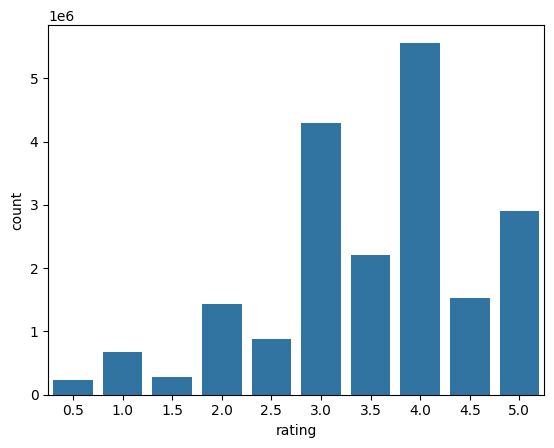

In [33]:
sns.countplot(x = "rating", data = movie_ratings)

<Axes: xlabel='rating'>

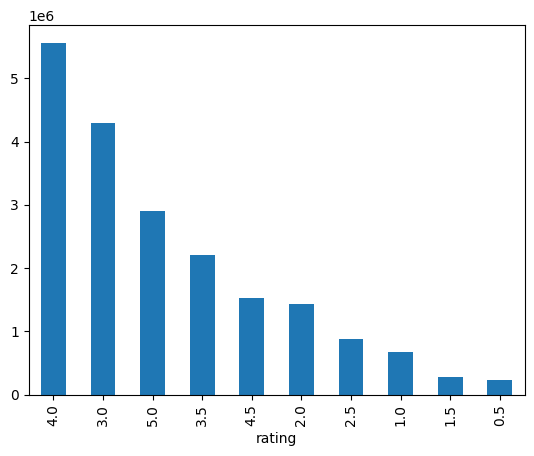

In [35]:
movie_ratings['rating'].value_counts().plot(kind='bar')

date column

In [ ]:
print(f"Count of unique dates: {movie_ratings['date'].nunique()}")
print(f"First rating date: {movie_ratings['date'].min()}")
print(f"Last rating date: {movie_ratings['date'].max()}")
print(f"5 most common dates when ratings were given: {movie_ratings['date'].value_counts()[:5]}")